In [15]:
# Core libraries
import pandas as pd
import numpy as np

# CV
from sklearn.model_selection import StratifiedKFold

# Pipelines
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Custom preprocessing
import sys
sys.path.append('../')
from feature import PreProcessor

In [16]:
# Load training data
train_df = pd.read_csv('../data/train.csv')
train_df.drop(columns=['PassengerId'], inplace=True)

TARGET = 'Survived'
X = train_df.drop(columns=[TARGET])
y = train_df[TARGET].values

In [17]:
# Stratified K-Fold for OOF stacking
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [18]:
# XGBoost (anchor model)
xgb_pipe = Pipeline([
    ('preprocessor', PreProcessor(scaling=False)),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=5,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

In [19]:
# KNN (local pattern specialist)
knn_pipe = Pipeline([
    ('preprocessor', PreProcessor(scaling=True)),
    ('model', KNeighborsClassifier(n_neighbors=19))
])

In [20]:
# Containers for OOF probabilities
oof_xgb = np.zeros(len(X))
oof_knn = np.zeros(len(X))

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr = y[train_idx]

    # XGB
    xgb_pipe.fit(X_tr, y_tr)
    oof_xgb[val_idx] = xgb_pipe.predict_proba(X_va)[:, 1]

    # KNN
    knn_pipe.fit(X_tr, y_tr)
    oof_knn[val_idx] = knn_pipe.predict_proba(X_va)[:, 1]

In [21]:
# Meta features are OOF probabilities
X_meta = np.column_stack([oof_xgb, oof_knn])

X_meta[:5]

array([[0.04207158, 0.05263158],
       [0.97883421, 1.        ],
       [0.50140268, 0.42105263],
       [0.99278921, 0.94736842],
       [0.13804503, 0.21052632]])

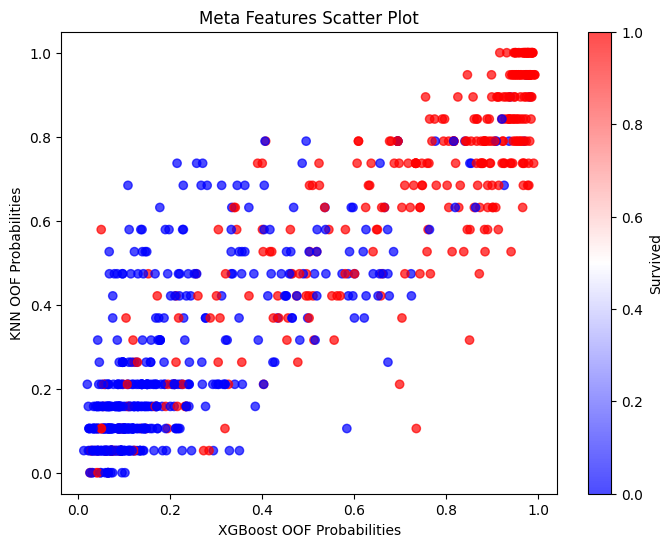

In [22]:
#scatter plot meta features with respect to target variable
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_meta[:, 0], X_meta[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.xlabel('XGBoost OOF Probabilities')
plt.ylabel('KNN OOF Probabilities')
plt.title('Meta Features Scatter Plot')
plt.colorbar(label='Survived')
plt.show()

In [23]:
# Conservative meta-model
meta_model = LogisticRegression(
    C=0.1,              # strong regularization
    solver='liblinear',
    random_state=42
)

meta_model.fit(X_meta, y)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [24]:
from sklearn.metrics import accuracy_score

# Meta-model predictions on OOF data
oof_meta_pred = meta_model.predict(X_meta)

# Stacking accuracy (OOF-based)
stacking_oof_accuracy = accuracy_score(y, oof_meta_pred)

stacking_oof_accuracy

0.835016835016835

In [25]:
# Refit base models on entire training data
xgb_pipe.fit(X, y)
knn_pipe.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,scaling,True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",19
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to b

In [26]:
# Load test data
test_df = pd.read_csv('../data/test.csv')
test_passenger_ids = test_df['PassengerId']
test_df.drop(columns=['PassengerId'], inplace=True)

In [27]:
# Base model probabilities on test data
test_xgb_prob = xgb_pipe.predict_proba(test_df)[:, 1]
test_knn_prob = knn_pipe.predict_proba(test_df)[:, 1]

# Meta features
X_test_meta = np.column_stack([test_xgb_prob, test_knn_prob])

In [28]:
# Final stacked predictions
test_pred = meta_model.predict(X_test_meta)

test_pred[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [29]:
# Save submission
output_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_pred
})

output_df.to_csv('../output/stack_xgb_knn.csv', index=False)